# Approximate $\tau_0$ and scale the burst drift

$ \tau_0 \simeq \frac{b}{\cos\theta} $ Where $b$ is the minor axis of the gaussian fit to the burst autocorrelation.
Then, if $d\nu_{\text{obs}} / dt_{\text{obs}}$ is the burst drift, we expect 


### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}}=\frac{\nu_{\text{obs}}^{2}}{\nu_{0}\tau_{0}}\simeq\frac{\nu_{\text{obs}}^{2}b}{\nu_{0}\cos\theta}$

In [73]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts121102 = pd.read_csv('../bursts.csv')
bursts121102 = bursts121102.set_index('name')

##########
bursts180916 = pd.merge(pd.read_csv('data/CHIME_180916.J0158+65/chime_180916_fit_params_real.csv'),
                        pd.read_csv('data/CHIME_180916.J0158+65/chime_180916_param_errors_real.csv'),
                        how='left', on='name')
bursts180916 = bursts180916.set_index('name')

#########
bursts180814 = pd.merge(pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_img_fit_params.csv'),
                        pd.read_csv('data/CHIME_FRB180814.J0422+73/chime_180814_img_param_errors.csv'),
                        how='left', on='name')
bursts180814 = bursts180814.set_index('name')
# Correct sigmax and sigmay for pixel scale
bursts180814['sigmax'] = bursts180814[['sigmaxp', 'xscale']].apply(lambda row: abs(row['sigmaxp'])/row['xscale'], axis=1)
bursts180814['sigmay'] = bursts180814[['sigmayp', 'yscale']].apply(lambda row: abs(row['sigmayp'])/row['yscale'], axis=1)
bursts180814['sigmax_error'] = bursts180814[['sigmaxp_error', 'xscale']].apply(lambda row: abs(row['sigmaxp_error'])/row['xscale'], axis=1)
bursts180814['sigmay_error'] = bursts180814[['sigmayp_error', 'yscale']].apply(lambda row: abs(row['sigmayp_error'])/row['yscale'], axis=1)

# Set redshifts
bursts121102['z'] = 0.19273 # (josephy et al. 2019, frbcat.org)
bursts180916['z'] = 0.0337  # (chime 2020b et al.)
bursts180814['z'] = 0.05    # not accurate, z < 0.1 (amiri et al. 2019)

# bursts121102
bursts180814

,amplitude,xo,yo,sigmaxp,sigmayp,theta,drift (mhz/ms),angle,xscale,yscale,...,sigmaxp_error,sigmayp_error,angle_error,drift error (mhz/ms),red_chisq,sigmax,sigmay,sigmax_error,sigmay_error,z
name,,,,,,,,,,,,,,,,,,,,,
burst180814,170.460929,348.482341,650.515381,13.423814,86.414958,-9.544872,-13.994177,11.115669,2.697674,10.15625,...,0.009794,0.063051,0.000164,0.019321,7.935805,4.976069,8.508550,0.003630,0.006208,0.05
burst180911,161.775841,348.475970,650.475781,11.509405,51.025758,-9.455869,-54.298078,11.026666,2.697674,10.15625,...,0.008604,0.038134,0.000251,0.439138,8.177593,4.266417,5.024075,0.003189,0.003755,0.05
burst180917,114.783963,348.498284,650.523744,25.229454,166.514516,-9.645794,-3.758155,11.216591,2.697674,10.15625,...,0.005132,0.033874,0.000045,0.000784,11.837501,9.352298,16.395275,0.001903,0.003335,0.05
burst180919,124.668419,348.473626,650.485046,19.671831,38.082662,-9.370266,30.948518,10.941062,2.697674,10.15625,...,0.021844,0.042295,0.001106,0.629375,7.448608,7.292144,3.749677,0.008097,0.004164,0.05
burst181028,422.907745,348.498487,650.512116,26.454510,-74.532726,-9.835755,-5.852370,11.406551,1.359375,10.15625,...,0.003260,0.009184,0.000071,0.001131,11.809635,19.460789,7.338607,0.002398,0.000904,0.05


## Compute 121102 details

Text(0.5, 0, 'Burst #')

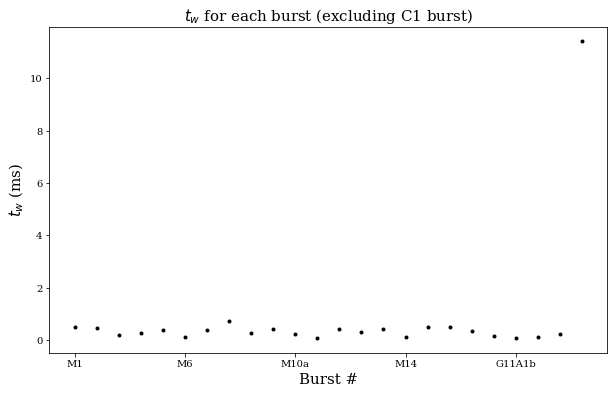

In [74]:
bursts121102['drift_abs'] = abs(bursts121102['drift (mhz/ms)'])
bursts121102['drift_over_nuobs'] = bursts121102[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts121102['min_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts121102['max_sigma'] = bursts121102[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)

# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts121102['min_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts121102['max_sigma_error'] = bursts121102[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts121102['sigma_t']   = bursts121102[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts121102['tau_w'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts121102['tau_w_error'] = bursts121102[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts121102['sigma_t_ms'] = bursts121102['sigma_t']*1e3
bursts121102['tau_w_ms'] = bursts121102['tau_w']*1e3

## C1 
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12

## Redshift corrections
bursts121102['drift_z'] = bursts121102[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts121102['tau_w_ms_z'] = bursts121102[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
fontsize=15

selectbursts121102 = bursts121102.loc[bursts121102_to_include]
ax = selectbursts121102['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ for each burst (excluding C1 burst)", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')

## Compute 180916 details

Text(0.5, 0, 'Burst #')

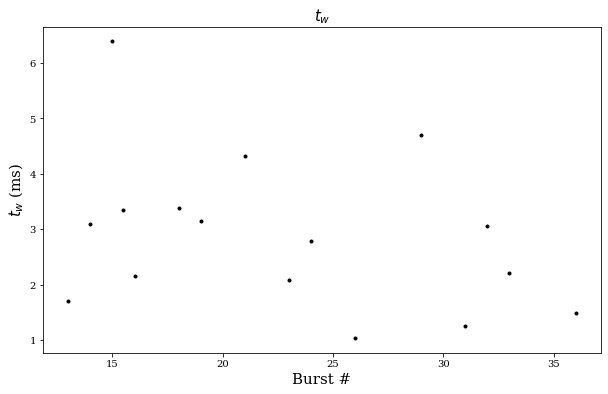

In [75]:
bursts180916['drift_abs'] = abs(bursts180916['drift (mhz/ms)'])
bursts180916['drift_over_nuobs'] = bursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts180916['min_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts180916['max_sigma'] = bursts180916[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180916['min_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180916['max_sigma_error'] = bursts180916[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180916['sigma_t']   = bursts180916[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180916['tau_w'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180916['tau_w_error'] = bursts180916[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180916['sigma_t_ms'] = bursts180916['sigma_t']*1e3
bursts180916['tau_w_ms'] = bursts180916['tau_w']*1e3

## Redshift corrections
bursts180916['drift_z'] = bursts180916[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts180916['tau_w_ms_z'] = bursts180916[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)

fontsize=15

selectbursts180916 = bursts180916
ax = selectbursts180916['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180916[['tau_w_ms', 'tau_w_error']]

## Compute 180814 Details

Text(0.5, 0, 'Burst #')

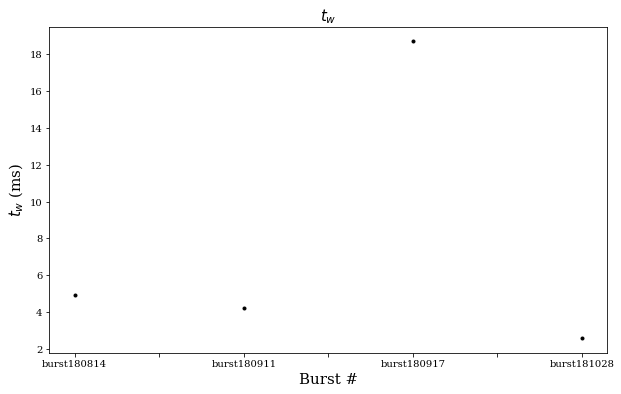

In [76]:
# bursts180814['drift_abs'] = abs(bursts180814['drift (mhz/ms)'])
bursts180814['drift_abs'] = -1*bursts180814['drift (mhz/ms)']
bursts180814['drift_over_nuobs'] = bursts180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs'] / row['center_f'], axis=1)
bursts180814['min_sigma'] = bursts180814[['sigmax','sigmay']].apply(lambda row: min(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
bursts180814['max_sigma'] = bursts180814[['sigmax','sigmay']].apply(lambda row: max(abs(row['sigmax']), abs(row['sigmay'])), axis=1)
# the following two lines assume that if sigmax > sigmay, then sigmax_error > sigmay_error, which is true (so far) for this dataset
bursts180814['min_sigma_error'] = bursts180814[['sigmax_error','sigmay_error']].apply(lambda row: min(row['sigmax_error'], row['sigmay_error']), axis=1)
bursts180814['max_sigma_error'] = bursts180814[['sigmax_error','sigmay_error']].apply(lambda row: max(row['sigmax_error'], row['sigmay_error']), axis=1)

bursts180814['sigma_t']   = bursts180814[['min_sigma','time_res']].apply(lambda row: row['min_sigma']*row['time_res'], axis=1)

bursts180814['tau_w'] = bursts180814[['time_res', 'min_sigma', 'max_sigma', 'angle']].apply(
    lambda r: r['time_res']*r['min_sigma']*r['max_sigma'] / np.sqrt( np.abs((np.sin(r['angle']-np.pi/2)*r['min_sigma'])**2 + (np.cos(r['angle']-np.pi/2)*r['max_sigma'])**2 )), 
    axis=1
)

# this error is in ms
bursts180814['tau_w_error'] = bursts180814[['time_res', 'min_sigma', 'max_sigma', 'min_sigma_error', 'max_sigma_error', 'angle', 'angle_error']].apply(
    lambda r: 1e3*r['time_res']*np.sqrt((r['angle_error']**2*r['max_sigma']**2*r['min_sigma']**2*(2*r['max_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2) - 2*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)*np.sin(r['angle']-np.pi/2))**2)/(4.*(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**3)+ r['min_sigma_error']**2*(-((r['max_sigma']*r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['max_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2+ r['max_sigma_error']**2*(-((r['max_sigma']**2*r['min_sigma']*np.sin(r['angle']-np.pi/2)**2)/(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2)**1.5) + r['min_sigma']/np.sqrt(r['min_sigma']**2*np.cos(r['angle']-np.pi/2)**2 + r['max_sigma']**2*np.sin(r['angle']-np.pi/2)**2))**2),
    axis=1
)

bursts180814['sigma_t_ms'] = bursts180814['sigma_t']*1e3
bursts180814['tau_w_ms'] = bursts180814['tau_w']*1e3

## Redshift corrections
bursts180814['drift_z'] = bursts180814[['drift_over_nuobs', 'z']].apply(lambda row: row['drift_over_nuobs']*(1+row['z']), axis=1)
bursts180814['tau_w_ms_z'] = bursts180814[['tau_w_ms', 'z']].apply(lambda row: row['tau_w_ms']/(1+row['z']), axis=1)


fontsize=15

selectbursts180814 = bursts180814.loc[['burst180814','burst180911','burst180917','burst181028']]
ax = selectbursts180814['tau_w_ms'].plot(style='k.', figsize=(10,6))
ax.set_title("$t_w$ ", size=fontsize)
ax.set_ylabel('$t_w$ (ms)', size=fontsize)
ax.set_xlabel('Burst #', size=fontsize)
# plt.savefig('tw.png')
# selectbursts180814[['tau_w_ms', 'tau_w_error']]

In [77]:
def reciprocal(x, a):
	return a/x

def reciprocal_log(x, b):
	return -x+b

def log_log(x, k, b):
	return k*x+b

def reciprocal_odr(B, x):
    return B[0]/x

def reciprocal_odr_log(B, x):
	return -x+B[0]

def fitreciprocal(x, data, sigma=1):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma

    sigma = np.zeros(len(data.ravel())) + sigma
    popt, pcov = scipy.optimize.curve_fit(reciprocal, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

def fitreciprocal_log(x, data, sigma=1, loglog=False):
    guess = [522]
    abs_sigma = True
    if (type(sigma) == int) and (sigma == 1):
        abs_sigma = False
    sigma = np.zeros(len(data.ravel())) + sigma
    
    if loglog:
        guess = [1,1]
        popt, pcov = scipy.optimize.curve_fit(log_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    else:
        popt, pcov = scipy.optimize.curve_fit(reciprocal_log, x, data, p0=guess, sigma=sigma, absolute_sigma=abs_sigma)
    return popt, pcov

fit_model = scipy.odr.Model(reciprocal_odr)
fit_model_log = scipy.odr.Model(reciprocal_odr_log)

In [86]:
selectbursts121102.head(23)

,filename,edge,angle,peak,sigmax,sigmay,Slope,drift (mhz/ms),drift error (mhz/ms),center,...,min_sigma_error,max_sigma_error,sigma_t,tau_w,tau_w_error,sigma_t_ms,tau_w_ms,drift_z,tau_w_ms_z,color
name,,,,,,,,,,,,,,,,,,,,,
M1,01_puppi_57747_C0531+33_0558_5.dm559.72.calibP...,1525.0,1.720000,1.042900e+04,173.731526,47.364587,-6.652439,-1039.359422,0.190767,228.755888,...,0.003007,0.011140,0.000485,0.000490,0.000101,0.485013,0.490051,0.278066,0.410865,r
M2,02_puppi_57747_C0531+33_0558_1183.dm559.72.cal...,1850.0,1.780000,5.692000e+03,177.080918,44.911875,-4.736866,-740.578566,0.652317,209.060564,...,0.020486,0.081784,0.000460,0.000469,0.000650,0.459898,0.469468,0.199508,0.393608,r
M3,03_puppi_57747_C0531+33_0558_1202.dm559.72.cal...,1975.0,1.620000,5.668000e+03,169.749001,19.463885,-19.669528,-2823.770453,2.623174,249.051665,...,0.005950,0.052822,0.000199,0.000200,0.000495,0.199310,0.199549,0.750123,0.167304,r
M4,04_puppi_57747_C0531+33_0558_25437.dm559.72.ca...,1450.0,1.710000,5.038000e+03,160.360329,26.706231,-7.137257,-1104.756403,21.768613,322.029396,...,0.292807,1.780140,0.000273,0.000276,0.014013,0.273472,0.276068,0.286205,0.231459,r
M5,05_puppi_57747_C0531+33_0558_3683.dm559.72.cal...,1450.0,1.639204,5.031000e+03,37.747383,166.280492,-14.595503,-2111.819665,67.749909,214.396765,...,0.258022,1.153948,0.000387,0.000387,0.011306,0.386533,0.387393,0.567844,0.324795,r
M6,06_puppi_57747_C0531+33_0558_3687.dm559.72.cal...,1150.0,1.590000,5.569000e+03,156.557708,12.416683,-52.066970,-6051.049490,11.249634,263.938012,...,0.005173,0.065385,0.000127,0.000127,0.000650,0.127147,0.127170,1.599152,0.106621,r
M7,07_puppi_57747_C0531+33_0558_3688.dm559.72.cal...,1590.0,1.720000,5.821000e+03,102.259272,38.969184,-6.652439,-1019.972935,0.845772,160.167242,...,0.007547,0.019954,0.000399,0.000403,0.000192,0.399044,0.402867,0.279600,0.337769,r
M8,08_puppi_57747_C0531+33_0558_3689.dm559.72.cal...,2000.0,1.990000,5.666000e+03,171.395398,64.792725,-2.244076,-340.369797,0.064490,296.067560,...,0.007370,0.019619,0.000663,0.000716,0.000141,0.663478,0.716279,0.088962,0.600538,r
M9a,09_puppi_57747_C0531+33_0558_3690.dm559.72.cal...,NaN,1.671361,1.822146e+00,24.652299,113.948254,-9.910317,-1512.194326,152.486918,252.333410,...,0.772813,3.567355,0.000252,0.000254,0.033299,0.252440,0.253661,0.401250,0.212673,r


In [78]:
# Color by source
selectbursts121102['color'] = 'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'b'
selectbursts180916['color'] = 'm'
selectbursts180814['color'] = 'y'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)

# selectbursts['drift error (mhz/ms)']['M8'] = 0.06448979034795*1

michillibursts['drift_z_abs'] = michillibursts[['drift_abs', 'z']].apply(lambda row: row['drift_abs']*(1+row['z'])**2, axis=1)

# Correct to the average Michilli burst frequency:
nu_obs0 = np.mean(michillibursts[['center_f']])
print(nu_obs0)
otherbursts['drift_corr'] = otherbursts[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['drift_err_corr'] = otherbursts[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
otherbursts['tau_w_ms_corr'] = otherbursts[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['tau_w_err_corr'] = otherbursts[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
otherbursts['drift_z_corr'] = otherbursts[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
otherbursts['tau_w_ms_z_corr'] = otherbursts[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

selectbursts180916['drift_corr'] = selectbursts180916[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['drift_err_corr'] = selectbursts180916[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180916['tau_w_ms_corr'] = selectbursts180916[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['tau_w_err_corr'] = selectbursts180916[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180916['drift_z_corr'] = selectbursts180916[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
selectbursts180916['tau_w_ms_z_corr'] = selectbursts180916[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

selectbursts180814['drift_corr'] = selectbursts180814[['drift_abs','center_f']].apply(lambda row: row['drift_abs']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180814['drift_err_corr'] = selectbursts180814[['drift error (mhz/ms)','center_f']].apply(lambda row: row['drift error (mhz/ms)']*(nu_obs0 / row['center_f'])**2, axis=1)
selectbursts180814['tau_w_ms_corr'] = selectbursts180814[['tau_w_ms','center_f']].apply(lambda row: row['tau_w_ms']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180814['tau_w_err_corr'] = selectbursts180814[['tau_w_error','center_f']].apply(lambda row: row['tau_w_error']*(row['center_f'] / nu_obs0), axis=1)
selectbursts180814['drift_z_corr'] = selectbursts180814[['drift_corr', 'z']].apply(lambda row: row['drift_corr']*(1+row['z'])**2, axis=1)
selectbursts180814['tau_w_ms_z_corr'] = selectbursts180814[['tau_w_ms_corr', 'z']].apply(lambda row: row['tau_w_ms_corr']/(1+row['z']), axis=1)

# print(nu_obs0)
# otherbursts[['tau_w_ms', 'tau_w_ms_corr', 'drift_abs', 'drift_corr', 'tau_w_error', 'tau_w_err_corr', 'drift error (mhz/ms)', 'drift_err_corr', 'center_f', ]]

center_f    4472.188306
dtype: float64


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

# Drift normalized by observing frequency vs. Burst Duration

[0.11347956] [1.10634663]
[0.0850718] [1.11805148]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


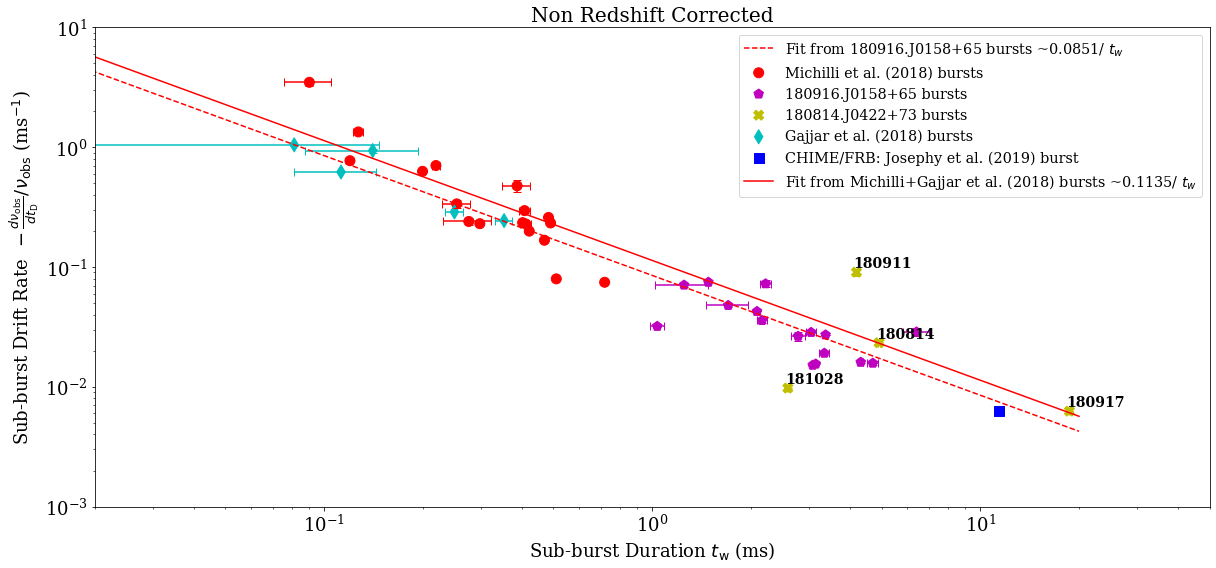

In [94]:
# michili fit
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration' if logscale else 'drift_over_nu_obsvsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error'], 
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_error'], 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_error'], 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error'], 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error'], 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 50)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} / \\nu_\\mathrm{obs}$ (ms$^{-1}$)', size=fontsize)

# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(23)['tau_w_ms']), 
                             np.log(selectbursts121102.head(23)['drift_over_nuobs']),
                             sx=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['tau_w_error']), 
                             sy=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['drift error (mhz/ms)']/selectbursts121102.head(23)['center_f']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z']), 
                             np.log(selectbursts180916['drift_z']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli+Gajjar et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str((round(opt[0], 4))) + '/ $t_w$')

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.title("Non Redshift Corrected", size=20)
plt.tight_layout()

for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))

# Redshift Corrected #1

To correct for redshift we scale 
### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}} \times \nu_{obs}^{-1} \times (1+z)$ and $t_w \,/\, (1+z)$

[0.11268937] [1.10537786]
[0.0850718] [1.11805148]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


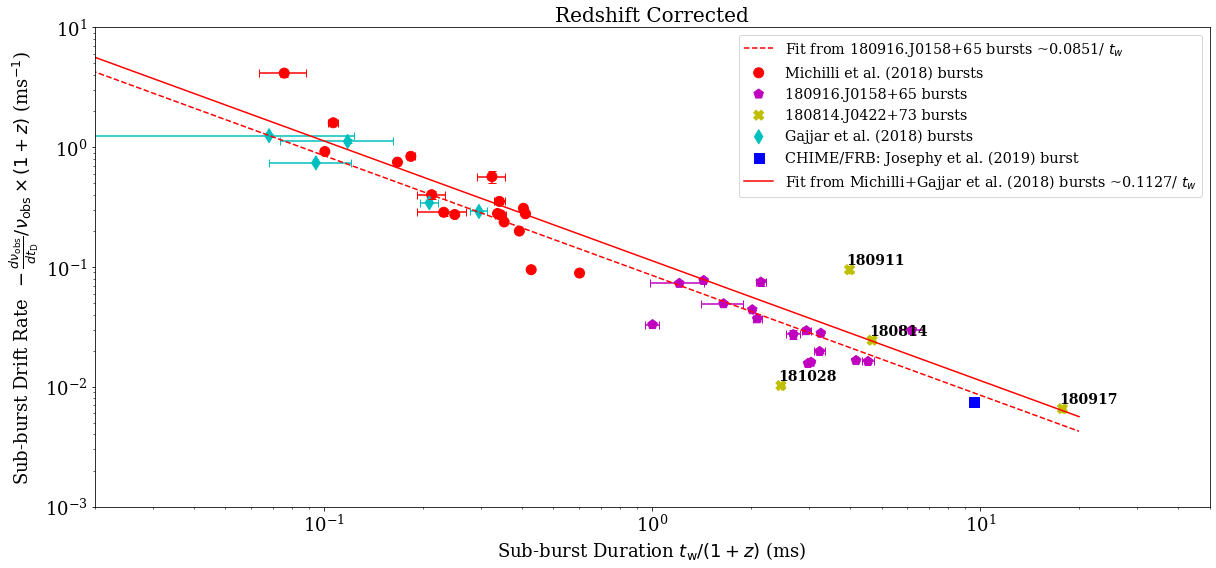

In [95]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_z_vsduration' if logscale else 'drift_z_vsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms_z', y='drift_z', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z']),
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z'])/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z']), 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_error']/(1+selectbursts180814['z']), 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift error (mhz/ms)']*(1+selectbursts180814['z'])/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']*(1+otherbursts['z'])/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_z', y='drift_z',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_error']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift error (mhz/ms)']*(1+otherbursts['z'])/otherbursts['center_f'], 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms_z'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms_z'], v['drift_z']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 50)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w} / (1+z)$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} / \\nu_\\mathrm{obs} \\times (1+z)$ (ms$^{-1}$)', size=fontsize)


# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(23)['tau_w_ms_z']), 
                             np.log(selectbursts121102.head(23)['drift_z']),
                             sx=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['tau_w_error']/(1+selectbursts121102.head(23)['z'])), 
                             sy=np.log(selectbursts121102.head(23)['red_chisq']*selectbursts121102.head(23)['drift error (mhz/ms)']*(1+selectbursts121102.head(23)['z'])/selectbursts121102.head(23)['center_f'] ))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z']), 
                             np.log(selectbursts180916['drift_z']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_error']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift error (mhz/ms)']*(1+selectbursts180916['z'])/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli+Gajjar et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str((round(opt[0], 4))) + '/ $t_w$')

# plt.plot(x, odrfit.beta[0]/x, 'b-', label='6. x and y error \t\t${:.2f} \pm {:.2f}$'.format(odrfit.beta[0], odrfit.sd_beta[0])+'/$t_w$')

# a = np.exp(popt_log_log[1])
# k = popt_log_log[0]
# plt.plot(x, a * x**k, 'r-', label='loglog \t\t\t\t\t${:.2f}~t_w^{{{:.2f}}}$'.format(a,k))

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.title("Redshift Corrected", size=20)
plt.tight_layout()

for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))

# Redshift Corrected #2

To correct for redshift we correct the drifts and durations to the Michilli observing frequency and then scale 
### $\frac{d\nu_{\text{obs}}}{dt_{\text{obs}}} \times (1+z)^2$ and $t_w \,/\, (1+z)$

[529.81643043] [1.11078483]
[360.82944632] [1.11312068]


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


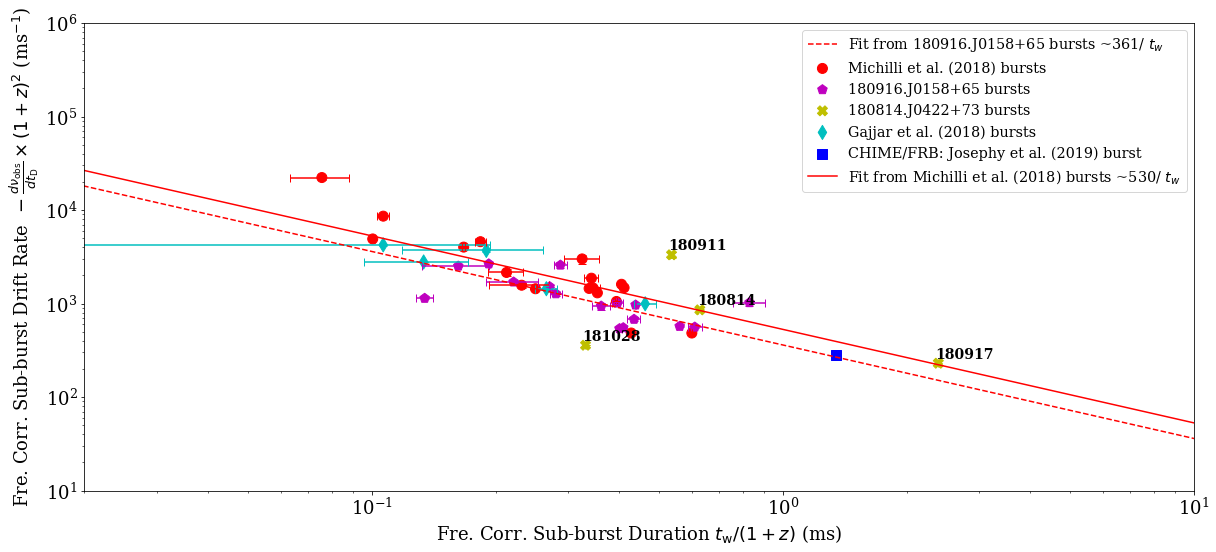

In [46]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 100
fontsize = 18
annotsize = 14
logscale = True
filename = 'log_drift_z_vsduration' if logscale else 'drift_z_vsduration'
figsize = (17, 8)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms_z', y='drift_z_abs', 
                               xerr=michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z']),
                               yerr=michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o',
                               label='Michilli et al. (2018) bursts')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr', 
                               xerr=selectbursts180916['red_chisq']*selectbursts180916['tau_w_err_corr']/(1+selectbursts180916['z']), 
                               yerr=selectbursts180916['red_chisq']*selectbursts180916['drift_err_corr']*(1+selectbursts180916['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p',
                               label='180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr', 
                               xerr=selectbursts180814['red_chisq']*selectbursts180814['tau_w_err_corr']/(1+selectbursts180814['z']), 
                               yerr=selectbursts180814['red_chisq']*selectbursts180814['drift_err_corr']*(1+selectbursts180814['z'])**2, 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X',
                               label='180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr']*(1+otherbursts['z'])**2, 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='Gajjar et al. (2018) bursts')
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms_z_corr', y='drift_z_corr',
                         xerr=otherbursts['red_chisq']*otherbursts['tau_w_err_corr']/(1+otherbursts['z']), 
                         yerr=otherbursts['red_chisq']*otherbursts['drift_err_corr']*(1+otherbursts['z'])**2, 
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='CHIME/FRB: Josephy et al. (2019) burst')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms_z'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in selectbursts180814.iterrows():
    ax.annotate(k.split('burst')[1], (v['tau_w_ms_z_corr'], v['drift_z_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    ax.set_xlim(-0.1, 20)
    ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.02, 10)
    ax.set_ylim(10**1, 10**6)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Fre. Corr. Sub-burst Duration $t_\\mathrm{w} / (1+z)$ (ms)', size=fontsize)
ax.set_ylabel('Fre. Corr. Sub-burst Drift Rate $\,-\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}} \\times (1+z)^2$ (ms$^{-1}$)', size=fontsize)

# ODR fit log
fitdata_log = scipy.odr.RealData(np.log(michillibursts['tau_w_ms_z']), 
                             np.log(michillibursts['drift_z_abs']),
                             sx=np.log(michillibursts['red_chisq']*michillibursts['tau_w_error']/(1+michillibursts['z'])), 
                             sy=np.log(michillibursts['red_chisq']*michillibursts['drift error (mhz/ms)']*(1+michillibursts['z']**2)))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms_z_corr']), 
                             np.log(selectbursts180916['drift_z_corr']),
                             sx=np.log(selectbursts180916['red_chisq']*selectbursts180916['tau_w_err_corr']/(1+selectbursts180916['z'])), 
                             sy=np.log(selectbursts180916['red_chisq']*selectbursts180916['drift_err_corr']*(1+selectbursts180916['z']**2)))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta)]
errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta)]
names = ['Fit from Michilli et al. (2018) bursts', 'Fit from 180916.J0158+65 bursts']
ls    = ['r-', 'r--']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    plt.plot(x, opt[0]/x, l, label=name + ' ~' + str(int(round(opt[0]))) + '/ $t_w$')

handles, labels = ax.get_legend_handles_labels()
handles = handles [1:] + [handles[0]]
labels = labels [1:] + [labels[0]]
plt.legend(handles, labels, fontsize='x-large')

plt.tight_layout()
# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))